# Segmented deformable mirrors

We will use segmented deformable mirrors and simulate the PSFs that result from segment pistons and tilts. We will compare this functionality against Poppy, another optical propagation package.

First we'll import all packages.

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import astropy.units as u
import hcipy
import poppy

%matplotlib inline

In [2]:
# Parameters - these will depend on the aperture function you use
PUP_DIAMETER = 0.019725   # m
GAPSIZE = 90e-6  # m
FLATTOFLAT = PUP_DIAMETER/7.   # m

# these will not
num_pix = 1024
wavelength = 638e-9
num_airy = 20
sampling = 4
norm = False

## Instantiate the segmented mirrors

### HCIPy SM: `hsm`

We need to generate a pupil grid for the aperture, and a focal grid and propagator for the focal plane images after the DM.

In [3]:
# HCIPy grids and propagator
pupil_grid = hcipy.make_pupil_grid(dims=num_pix, diameter=PUP_DIAMETER)
#focal_grid = hcipy.make_focal_grid(pupil_grid, sampling, num_airy, wavelength=wavelength)
focal_grid = hcipy.make_uniform_grid([2*num_airy*sampling]*2, 2*num_airy * wavelength / PUP_DIAMETER)
prop = hcipy.FraunhoferPropagator(pupil_grid, focal_grid)

We generate a segmented aperture for the segmented mirror. For convenience, we'll use the HiCAT pupil without spiders. We'll use supersampling to better resolve the segment gaps.

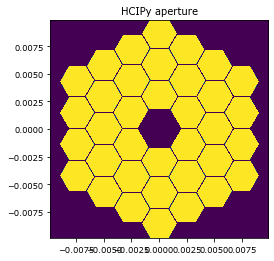

In [4]:
aper, segments = hcipy.make_hicat_aperture(normalized=norm, with_spiders=False, return_segments=True)
aper = hcipy.evaluate_supersampled(aper, pupil_grid, 2)
segments = hcipy.evaluate_supersampled(segments, pupil_grid, 2)

plt.title('HCIPy aperture')
hcipy.imshow_field(aper)

Now we make the segmented mirror. In order to be able to apply the SM to a plane, that plane needs to be a `Wavefront`, which combines a `Field` - here the aperture - with a wavelength, here `wavelength`.

In this example here, since the SM doesn't have any extra effects on the pupil since it's completely flat still, we don't actually have to apply the SM, although of course we could.

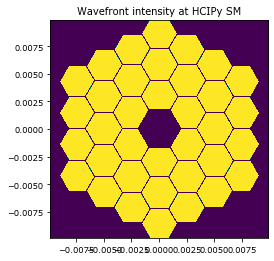

In [5]:
# Instantiate the segmented mirror
hsm = hcipy.SegmentedDeformableMirror(segments)

# Make a pupil plane wavefront from aperture
wf = hcipy.Wavefront(aper, wavelength)

# Apply SM if you want to
wf = hsm(wf)

plt.title('Wavefront intensity at HCIPy SM')
hcipy.imshow_field(wf.intensity)

### Poppy SM: `psm`

We'll do the same for Poppy.

In [6]:
psm = poppy.dms.HexSegmentedDeformableMirror(name='Poppy SM',
                                             rings=3,
                                             flattoflat=FLATTOFLAT*u.m,
                                             gap=GAPSIZE*u.m,
                                             center=False)

(<matplotlib.axes._subplots.AxesSubplot at 0x7f1e7b820ac8>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f1e7b792cf8>)

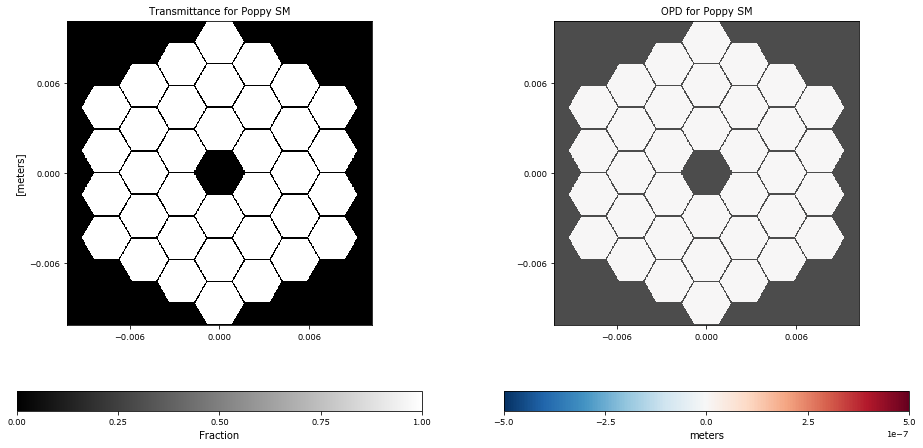

In [7]:
# Display the transmission and phase of the poppy sm
plt.figure(figsize=(16, 8))
psm.display(what='both')

## Create reference images

### HCIPy reference image

We need to apply the SM to the wavefront in the pupil plane and then propagate it to the image plane.

In [8]:
# Apply SM to pupil plane wf
wf_sm = hsm(wf)

# Propagate from SM to image plane
im_ref_hc = prop(wf_sm)

HCIPy PSF shape: (160, 160)


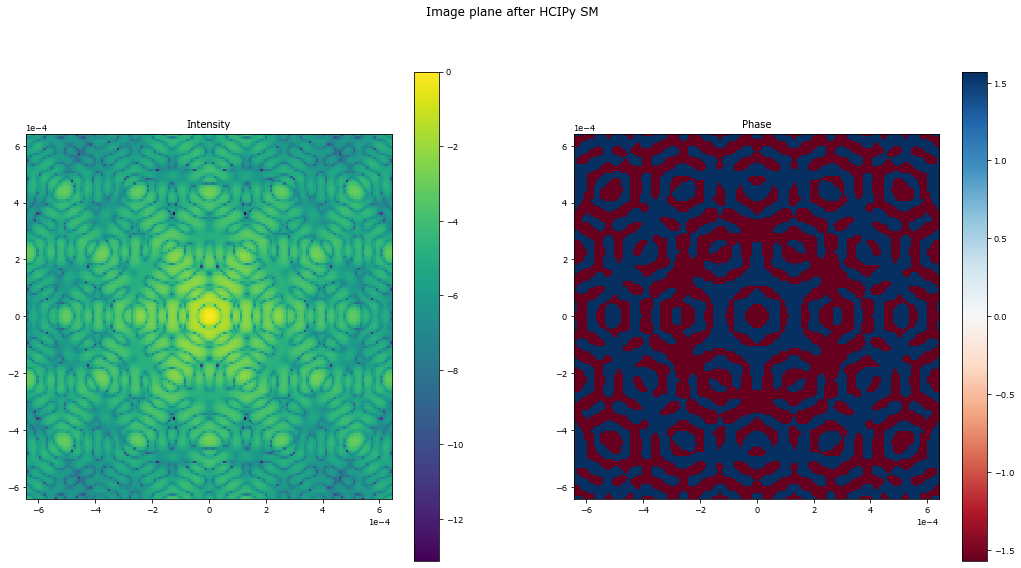

In [9]:
# Display intensity and phase in image plane
plt.figure(figsize=(18, 9))
plt.suptitle('Image plane after HCIPy SM')

# Get normalization factor for HCIPy reference image
norm_hc = np.max(im_ref_hc.intensity)

plt.subplot(1, 2, 1)
hcipy.imshow_field(np.log10(im_ref_hc.intensity/norm_hc))
plt.title('Intensity')
plt.colorbar()

plt.subplot(1, 2, 2)
hcipy.imshow_field(im_ref_hc.phase, cmap='RdBu')
plt.title('Phase')
plt.colorbar()

print('HCIPy PSF shape: {}'.format(im_ref_hc.intensity.shaped.shape))

### Poppy reference image

For the Poppy propagation, we need to make an optical system of which we then calculate the PSF.  

I will try to match the image resolution and size of the HCIPy image. I first adjust the `pixelscale` and `fov_arcsec` such that their ratio works and then I add a tweak factor `fac` to scale it to the HCIPy image. I also set `oversample` to something that matches the HCIPy sampling (it's close enough). I keep reusing these numbers and the tweak factor later on in the notebook.

In [10]:
# Make an optical system with the Poppy SM and a detector
psm.flatten()
osys = poppy.OpticalSystem()
osys.add_pupil(psm)
fac = 5300
pxscle = 10 * np.degrees(wavelength / PUP_DIAMETER) * 3600.0 / sampling * 0.97
fovarc = pxscle * 160 / 10
osys.add_detector(pixelscale=pxscle, fov_arcsec=fovarc, oversample=10)

Poppy PSF shape: (160, 160)


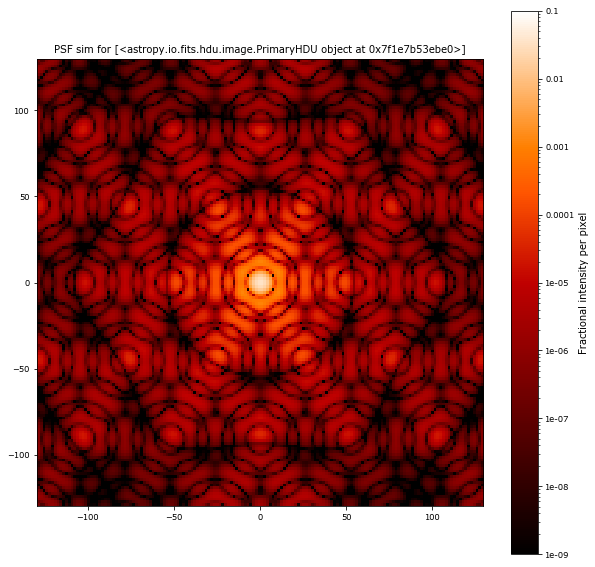

In [11]:
# Calculate the PSF
psf = osys.calc_psf(wavelength)
plt.figure(figsize=(10, 10))
poppy.display_psf(psf, vmin=1e-9, vmax=0.1)

# Get the PSF as an array
im_ref_pop = psf[0].data
print('Poppy PSF shape: {}'.format(im_ref_pop.shape))

# Get normalization from Poppy reference image
norm_pop = np.max(im_ref_pop)

### Both reference images side-by-side

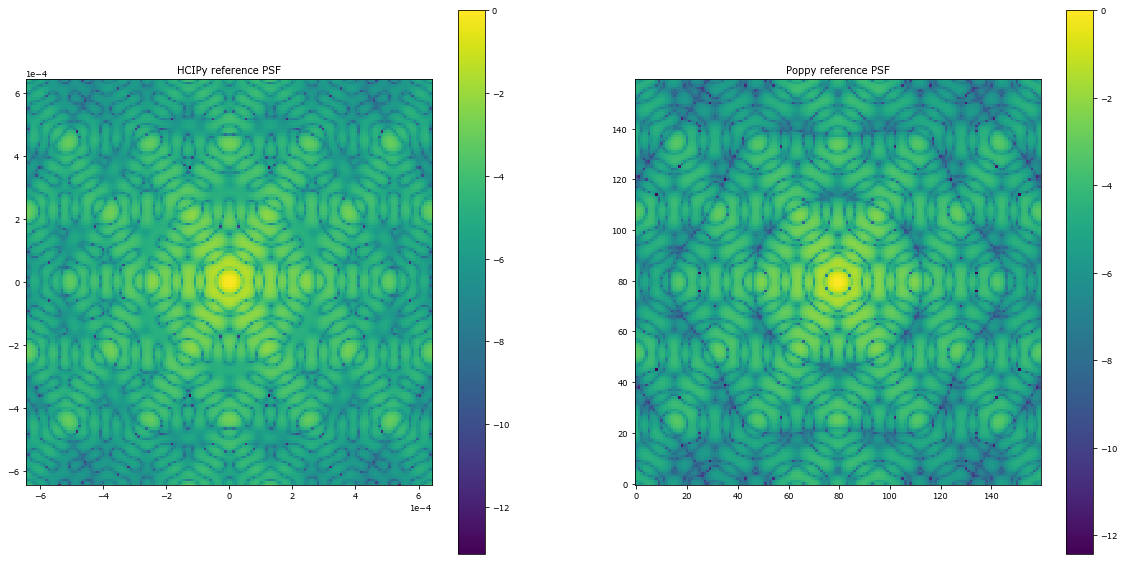

In [12]:
plt.figure(figsize=(20,10))

plt.subplot(1, 2, 1)
hcipy.imshow_field(np.log10(im_ref_hc.intensity / norm_hc))
plt.title('HCIPy reference PSF')
plt.colorbar()

plt.subplot(1, 2, 2)
plt.imshow(np.log10(im_ref_pop / norm_pop), origin='lower')
plt.title('Poppy reference PSF')
plt.colorbar()

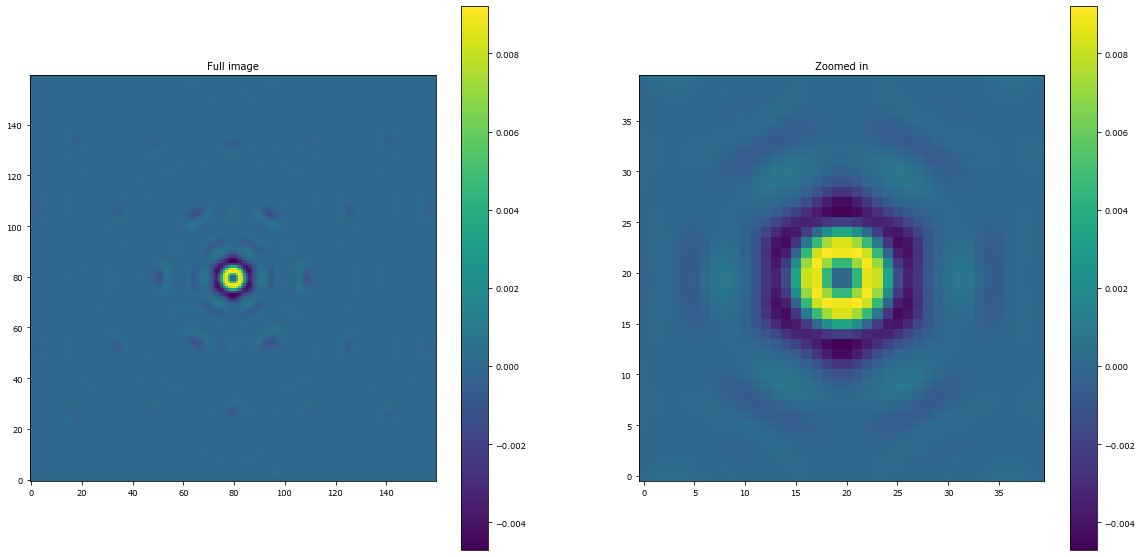

In [13]:
ref_dif = im_ref_pop / norm_pop - im_ref_hc.intensity.shaped / norm_hc

plt.figure(figsize=(20, 10))
plt.subplot(1, 2, 1)
plt.imshow(ref_dif, origin='lower')
plt.title('Full image')
plt.colorbar()
plt.subplot(1, 2, 2)
plt.imshow(ref_dif[60:100,60:100], origin='lower')
plt.title('Zoomed in')
plt.colorbar()

## Applying aberrations

In [14]:
# Define function from rad of phase to m OPD
def aber_to_opd(aber_rad, wavelength):
    aber_m = aber_rad * wavelength / (2 * np.pi)
    return aber_m
    
aber_rad = 4.0

print('Aberration: {} rad'.format(aber_rad))
print('Aberration: {} m'.format(aber_to_opd(aber_rad, wavelength)))

Aberration: 4.0 rad
Aberration: 4.061634147705169e-07 m


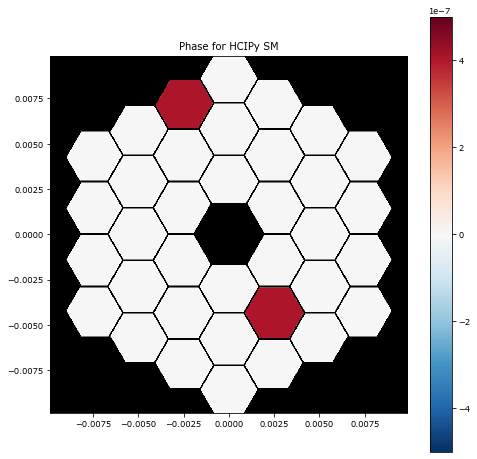

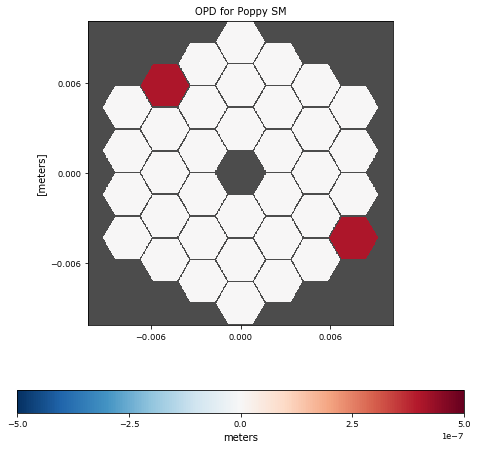

In [15]:
# Flatten both SMs just to be sure
hsm.flatten()
psm.flatten()

poppy_to_hcipy_index = {
    1: 2, 2: 1, 3: 0, 4: 5, 5: 4, 6: 3,
    7: 10, 8: 9, 9: 8, 10: 7, 11: 6, 12: 17, 13: 16, 14: 15, 15: 14, 16: 13, 17: 12, 18: 11,
    19: 24, 20: 23, 21: 22, 22: 21, 23: 20, 24: 19, 25: 18,
    26: 35, 27: 34, 28: 33, 29: 32, 30: 31, 31: 30, 32: 29, 33: 28, 34: 27, 35: 26, 36: 25}

for i in [35, 25]:
    hsm.set_segment_actuators(poppy_to_hcipy_index[i], aber_to_opd(aber_rad, wavelength) / 2, 0, 0)
    psm.set_actuator(i, aber_to_opd(aber_rad, wavelength) * u.m, 0, 0)
    
# Display both segmented mirrors in OPD

# HCIPy
plt.figure(figsize=(8,8))
plt.title('Phase for HCIPy SM')
hcipy.imshow_field(hsm.surface * 2, mask=aper, cmap='RdBu_r', vmin=-5e-7, vmax=5e-7)
plt.colorbar()

# Poppy
plt.figure(figsize=(8,8))
psm.display(what='opd')

### Show focal plane images

<Figure size 720x720 with 0 Axes>

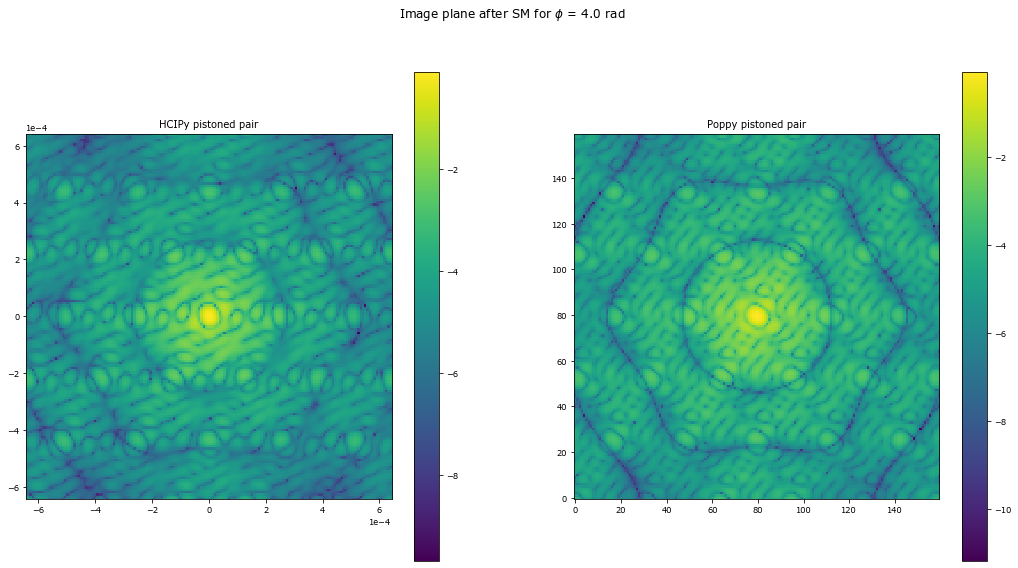

In [16]:
### HCIPy
# Apply SM to pupil plane wf
wf_fp_pistoned = hsm(wf)

# Propagate from SM to image plane
im_pistoned_hc = prop(wf_fp_pistoned)

### Poppy
# Make an optical system with the Poppy SM and a detector
osys = poppy.OpticalSystem()
osys.add_pupil(psm)
pxscle = 0.0031*fac      # I'm tweaking pixelscale and fov_arcsec to match the HCIPy image
fovarc = 0.05*fac
osys.add_detector(pixelscale=pxscle, fov_arcsec=fovarc, oversample=10)

# Calculate the PSF
psf = osys.calc_psf(wavelength)
plt.figure(figsize=(10, 10))

# Get the PSF as an array
im_pistoned_pop = psf[0].data

### Display intensity of both cases image plane
plt.figure(figsize=(18, 9))
plt.suptitle('Image plane after SM for $\phi$ = ' + str(aber_rad) + ' rad')

plt.subplot(1, 2, 1)
hcipy.imshow_field(np.log10(im_pistoned_hc.intensity / norm_hc))
plt.title('HCIPy pistoned pair')
plt.colorbar()

plt.subplot(1, 2, 2)
plt.imshow(np.log10(im_pistoned_pop / norm_pop), origin='lower')
plt.title('Poppy pistoned pair')
plt.colorbar()

### Image degradation as function of rms piston errors

We will plot the 

In [17]:
# Aberration range
aber_array = np.linspace(0, 2*np.pi, 50, True)
print('Aber in rad: \n{}'.format(aber_array))
print('Aber in m: \n{}'.format(aber_to_opd(aber_array, wavelength)))

# Apply pistons
hc_ims = []
pop_ims = []
for aber_rad in aber_array:
    # Flatten both SMs
    hsm.flatten()
    psm.flatten()

    # HCIPy
    for i in [34, 25]:
        opd = aber_to_opd(aber_rad, wavelength)
        hsm.set_segment_actuators(poppy_to_hcipy_index[i], opd / 2, 0, 0)   # hcipy uses SURFACE, not OPD
        psm.set_actuator(i, opd * u.m, 0, 0)

    # Propagate to image plane
    
    # HCIPy:
    # Propagate from pupil plane through SM to image plane
    im_pistoned_hc = prop(hsm(wf))

    # Poppy:
    # Make an optical system with the Poppy SM and a detector
    osys = poppy.OpticalSystem()
    osys.add_pupil(psm)
    pxscle = 0.0031 * fac  # I'm tweaking pixelscale and fov_arcsec to match the HCIPy image
    fovarc = 0.05 * fac
    osys.add_detector(pixelscale=pxscle, fov_arcsec=fovarc, oversample=10)

    # Calculate the PSF
    psf = osys.calc_psf(wavelength)

    # Get the PSF as an array
    im_pistoned_pop = psf[0].data

    hc_ims.append(im_pistoned_hc.intensity.shaped / im_pistoned_hc.intensity.max())
    pop_ims.append(im_pistoned_pop / im_pistoned_pop.max())
    
hc_ims = np.array(hc_ims)
pop_ims = np.array(pop_ims)

Aber in rad: 
[0.         0.12822827 0.25645654 0.38468481 0.51291309 0.64114136
 0.76936963 0.8975979  1.02582617 1.15405444 1.28228272 1.41051099
 1.53873926 1.66696753 1.7951958  1.92342407 2.05165235 2.17988062
 2.30810889 2.43633716 2.56456543 2.6927937  2.82102197 2.94925025
 3.07747852 3.20570679 3.33393506 3.46216333 3.5903916  3.71861988
 3.84684815 3.97507642 4.10330469 4.23153296 4.35976123 4.48798951
 4.61621778 4.74444605 4.87267432 5.00090259 5.12913086 5.25735913
 5.38558741 5.51381568 5.64204395 5.77027222 5.89850049 6.02672876
 6.15495704 6.28318531]
Aber in m: 
[0.00000000e+00 1.30204082e-08 2.60408163e-08 3.90612245e-08
 5.20816327e-08 6.51020408e-08 7.81224490e-08 9.11428571e-08
 1.04163265e-07 1.17183673e-07 1.30204082e-07 1.43224490e-07
 1.56244898e-07 1.69265306e-07 1.82285714e-07 1.95306122e-07
 2.08326531e-07 2.21346939e-07 2.34367347e-07 2.47387755e-07
 2.60408163e-07 2.73428571e-07 2.86448980e-07 2.99469388e-07
 3.12489796e-07 3.25510204e-07 3.38530612e-07 3.

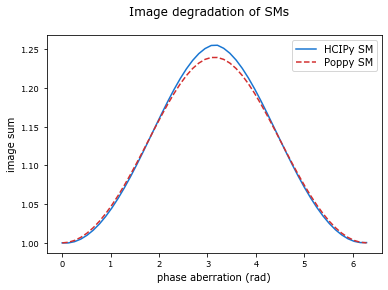

In [18]:
### Quantify with image sums
sum_hc = np.sum(hc_ims, axis=(1,2))
sum_hc /= sum_hc[0]
sum_pop = np.sum(pop_ims, axis=(1,2))
sum_pop /= sum_pop[0]

plt.suptitle('Image degradation of SMs')
plt.plot(aber_array, sum_hc, '-', label='HCIPy SM')
plt.plot(aber_array, sum_pop, '--', label='Poppy SM')
plt.xlabel('phase aberration (rad)')
plt.ylabel('image sum')
plt.legend()
plt.show()

## A mix of piston, tip and tilt (PTT)

In [19]:
aber_rad_tt = 500e-6
aber_rad_p = 1.8

opd_piston = aber_to_opd(aber_rad_p, wavelength)

### Put aberrations on both SMs
# Flatten both SMs
hsm.flatten()
psm.flatten()

## PISTON
for i in [19, 28, 23, 16]:
    hsm.set_segment_actuators(poppy_to_hcipy_index[i], opd_piston / 2, 0, 0)
    psm.set_actuator(i, opd_piston * u.m, 0, 0)
    
for i in [3, 35, 30, 8]:
    hsm.set_segment_actuators(poppy_to_hcipy_index[i], 0.5 * opd_piston / 2, 0, 0)
    psm.set_actuator(i, 0.5 * opd_piston * u.m, 0, 0)
    
for i in [14, 18, 1, 32, 12]:
    hsm.set_segment_actuators(poppy_to_hcipy_index[i], 0.3 * opd_piston / 2, 0, 0)
    psm.set_actuator(i, 0.3 * opd_piston * u.m, 0, 0)
    
## TIP and TILT
for i in [2, 5, 11, 15, 22]:
    hsm.set_segment_actuators(poppy_to_hcipy_index[i], 0, aber_rad_tt / 2, 0.3 * aber_rad_tt / 2)
    psm.set_actuator(i, 0, aber_rad_tt, 0.3 * aber_rad_tt)
    
for i in [4, 6, 36]:
    hsm.set_segment_actuators(poppy_to_hcipy_index[i], 0, aber_rad_tt / 2, 0)
    psm.set_actuator(i, 0, aber_rad_tt, 0)
    
for i in [34, 31, 7]:
    hsm.set_segment_actuators(poppy_to_hcipy_index[i], 0, 0, 1.3 * aber_rad_tt / 2)
    psm.set_actuator(i, 0, 0, 1.3 * aber_rad_tt)

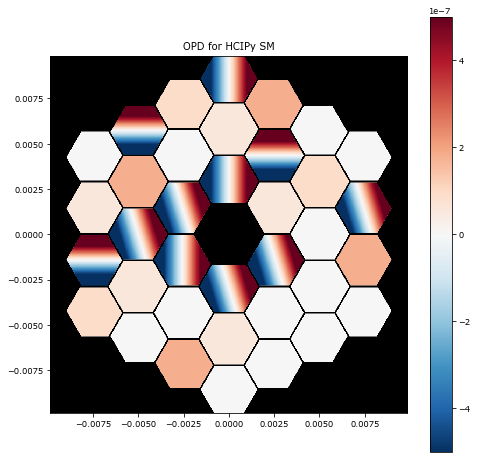

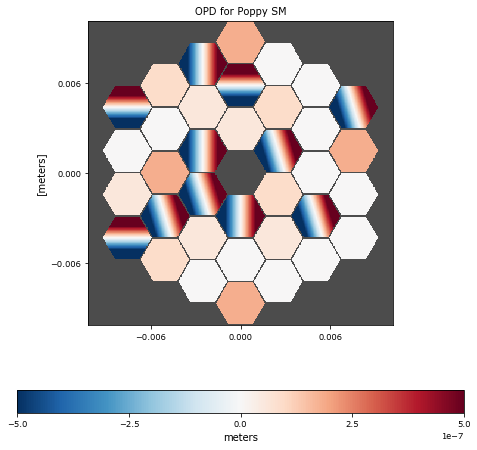

In [20]:
# Display both segmented mirrors in OPD

# HCIPy
plt.figure(figsize=(8,8))
plt.title('OPD for HCIPy SM')
hcipy.imshow_field(hsm.surface * 2, mask=aper, cmap='RdBu_r', vmin=-5e-7, vmax=5e-7)
plt.colorbar()

# Poppy
plt.figure(figsize=(8,8))
psm.display(what='opd')

In [21]:
### Propagate to image plane
## HCIPy
# Propagate from pupil plane through SM to image plane
im_pistoned_hc = prop(hsm(wf))

## Poppy
# Make an optical system with the Poppy SM and a detector
osys = poppy.OpticalSystem()
osys.add_pupil(psm)
pxscle = 0.0031 * fac  # I'm tweaking pixelscale and fov_arcsec to match the HCIPy image
fovarc = 0.05 * fac
osys.add_detector(pixelscale=pxscle, fov_arcsec=fovarc, oversample=10)

# Calculate the PSF
psf = osys.calc_psf(wavelength)

# Get the PSF as an array
im_pistoned_pop = psf[0].data

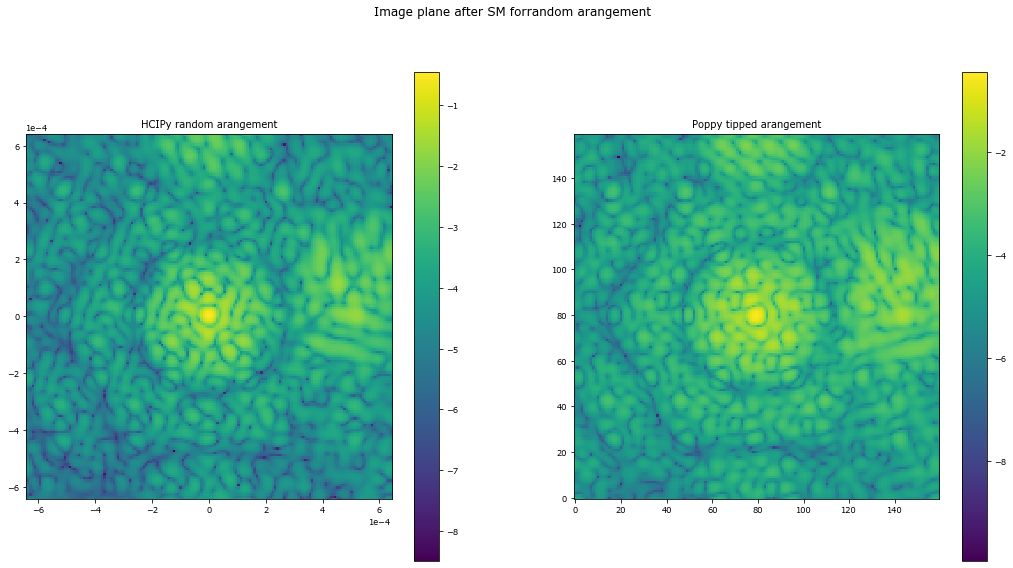

In [22]:
### Display intensity of both cases image plane
plt.figure(figsize=(18, 9))
plt.suptitle('Image plane after SM forrandom arangement')

plt.subplot(1, 2, 1)
hcipy.imshow_field(np.log10(im_pistoned_hc.intensity/norm_hc))
plt.title('HCIPy random arangement')
plt.colorbar()

plt.subplot(1, 2, 2)
plt.imshow(np.log10(im_pistoned_pop/norm_pop), origin='lower')
plt.title('Poppy tipped arangement')
plt.colorbar()
plt.show()